In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from arguments import Arguments
from svm import SVM
from collections import defaultdict
from distributor import get_cluster_sizes, get_distributed_data, \
    get_distributed_data_using_loader, get_fog_graph
from train import fog_train as train
from numpy import array
from numpy.random import permutation, randint
import os
import pickle as pkl
from sklearn.model_selection import train_test_split
import syft as sy
import torch
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from train import fog_train as train, test


In [4]:
# Setups
args = Arguments()
hook = sy.TorchHook(torch)
USE_CUDA = not args.no_cuda and torch.cuda.is_available()

torch.manual_seed(args.seed)
device = torch.device("cuda" if USE_CUDA else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if USE_CUDA else {}
kwargs = {}

In [5]:
ckpt_path = '../ckpts'
dataset = 'mnist'
clf_type = 'svm'
paradigm = 'fog_stratified_num_workers_{}_lr_{}_batch_{}'.format(
    args.num_workers,
    args.lr,
    args.batch_size
)
model_name = '{}_{}_{}'.format(dataset, clf_type, paradigm)
print(model_name)
init_path = '../init/mnist_svm.init'
best_path = os.path.join(ckpt_path, model_name + '.best')
stop_path = os.path.join(ckpt_path, model_name + '.stop')

mnist_svm_fog_stratified_num_workers_50_lr_0.03_batch_1200


In [12]:

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args.test_batch_size, shuffle=True, **kwargs)

for data, target in test_loader:
    X_test = data
    y_test = target

print('X_test: {}'.format(X_test.shape))
print('y_test: {}'.format(y_test.shape))

X_test: torch.Size([10000, 1, 28, 28])
y_test: torch.Size([10000])


In [7]:
# prepare graph and data
fog_graph, workers = get_fog_graph(hook, args.num_workers, args.num_clusters,
                                 args.shuffle_workers, args.uniform_clusters)
X_trains, y_trains = pkl.load(open('../ckpts/data_non_iid_10_stratify_True_uniform_True.pkl', 'rb'))
# X_trains, y_trains = get_distributed_data_using_loader(train_loader)
fog_graph

{'L1_W0': ['L0_W22', 'L0_W38', 'L0_W19', 'L0_W43', 'L0_W31'],
 'L1_W1': ['L0_W21', 'L0_W36', 'L0_W48', 'L0_W44', 'L0_W42'],
 'L1_W2': ['L0_W7', 'L0_W26', 'L0_W37', 'L0_W47', 'L0_W23'],
 'L1_W3': ['L0_W46', 'L0_W28', 'L0_W4', 'L0_W14', 'L0_W10'],
 'L1_W4': ['L0_W29', 'L0_W49', 'L0_W5', 'L0_W25', 'L0_W12'],
 'L1_W5': ['L0_W11', 'L0_W41', 'L0_W27', 'L0_W1', 'L0_W24'],
 'L1_W6': ['L0_W18', 'L0_W16', 'L0_W13', 'L0_W32', 'L0_W15'],
 'L1_W7': ['L0_W9', 'L0_W35', 'L0_W39', 'L0_W34', 'L0_W6'],
 'L1_W8': ['L0_W40', 'L0_W20', 'L0_W3', 'L0_W17', 'L0_W0'],
 'L1_W9': ['L0_W8', 'L0_W33', 'L0_W45', 'L0_W30', 'L0_W2'],
 'L2_W0': ['L1_W0', 'L1_W7'],
 'L2_W1': ['L1_W5', 'L1_W6'],
 'L2_W2': ['L1_W2', 'L1_W9'],
 'L2_W3': ['L1_W1', 'L1_W4'],
 'L2_W4': ['L1_W3', 'L1_W8'],
 'L3_W0': ['L2_W4', 'L2_W1', 'L2_W0'],
 'L3_W1': ['L2_W2', 'L2_W3'],
 'L4_W0': ['L3_W1', 'L3_W0']}

In [8]:
best = 0
# Fire the engines
model = SVM().to(device)
model.load_state_dict(torch.load(init_path))
print('Load init: {}'.format(init_path))



Load init: ../init/mnist_svm.init


In [ ]:
best = 0

y_ax = []
x_ax = []
for epoch in range(1, args.epochs + 1):
    train(args, model, fog_graph, workers, X_trains, y_trains,
          device, epoch, loss_fn='hinge')
    acc = test(args, model, device, test_loader, best, epoch)
    y_ax.append(acc)
    x_ax.append(epoch)
    
    if args.save_model and acc > best:
        best = acc
        torch.save(model.state_dict(), best_path)
        print('Model best  @ {}, acc {}: {}\n'.format(epoch, acc, best_path))
    
if (args.save_model):
    torch.save(model.state_dict(), stop_path)
    print('Model stop: {}'.format(stop_path))


In [11]:
import pickle as pkl
pkl.dump((x_ax, y_ax), open('../ckpts/history_{}.pkl'.format(model_name), 'wb'))  

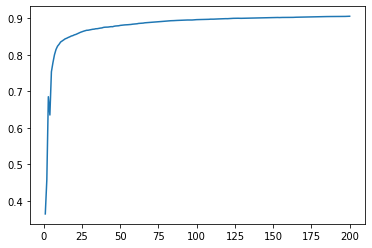

In [12]:
import matplotlib.pyplot as plt
plt.plot(x_ax, y_ax)
plt.savefig('../plots/{}.png'.format(model_name))

In [13]:
model_name

'mnist_svm_fog_stratified_num_workers_50_lr_0.03_batch_7000'